# Inferential Statistics in hotel dataset

Now, it's time to explore the hotel dataset and try to find trends and relationships.

The dataset has about 800 hotels with their ratings for 4 diffrent cities. The main parameters are **city, zip code, hotel star class, overall rating** and some **specific ratings** for the hotel.

First, we will import the data and show some relationships, and try to infer dependencies.

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
dfraw = pd.read_csv('Hotels_clean_merged.csv',index_col=False)

# drop non-meaningful data for statistics - that's like 300 rows which is a significant amount tho

dfbtr1 = dfraw[dfraw['class']<6]
dfbtr1 = dfbtr1[dfbtr1['class']>-1]
dfbtr1 = dfbtr1[dfbtr1['price']>0]

dfbtr1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 564 entries, 0 to 832
Data columns (total 15 columns):
hotel_name              564 non-null object
street                  564 non-null object
city                    564 non-null object
state                   564 non-null object
country                 564 non-null object
zip                     564 non-null int64
class                   564 non-null int64
price                   564 non-null float64
num_reviews             564 non-null int64
CLEANLINESS             564 non-null float64
ROOM                    564 non-null float64
SERVICE                 564 non-null float64
LOCATION                564 non-null float64
VALUE                   564 non-null float64
overall_ratingsource    564 non-null float64
dtypes: float64(7), int64(3), object(5)
memory usage: 70.5+ KB


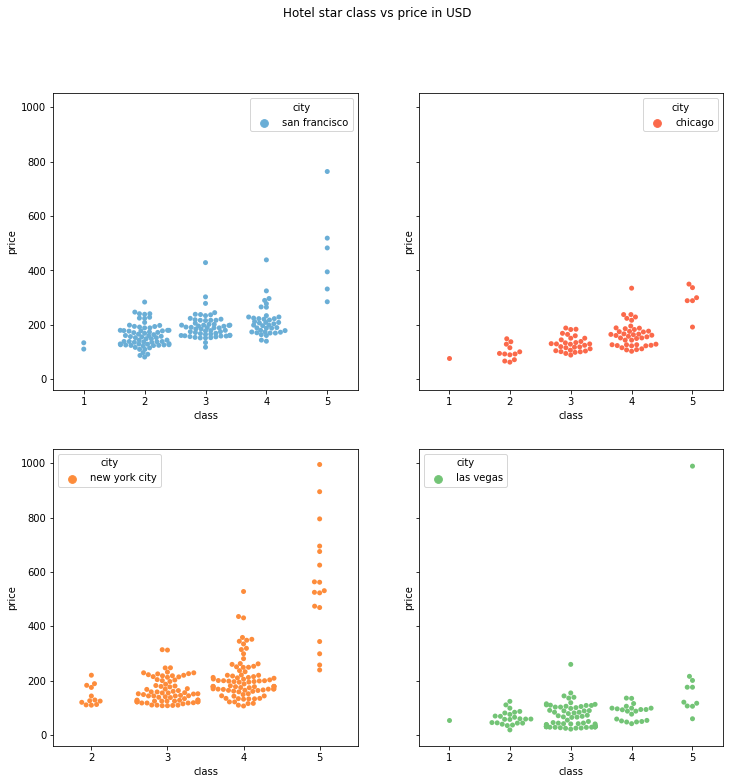

In [8]:
sanfran = dfbtr1[dfbtr1['city']=='san francisco']
iloveny = dfbtr1[dfbtr1['city']=='new york city']
eltrain = dfbtr1[dfbtr1['city']=='chicago']
sincity = dfbtr1[dfbtr1['city']=='las vegas']

f, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

sns.swarmplot(x="class", y="price", data=sanfran, palette='Blues', ax=axes[0, 0], hue='city')
sns.swarmplot(x="class", y="price", data=iloveny, palette='Oranges', ax=axes[1, 0], hue='city')
sns.swarmplot(x="class", y="price", data=eltrain, palette='Reds', ax=axes[0, 1], hue='city')
sns.swarmplot(x="class", y="price", data=sincity, palette='Greens', ax=axes[1, 1], hue='city')

f.suptitle('Hotel star class vs price in USD')
plt.show()

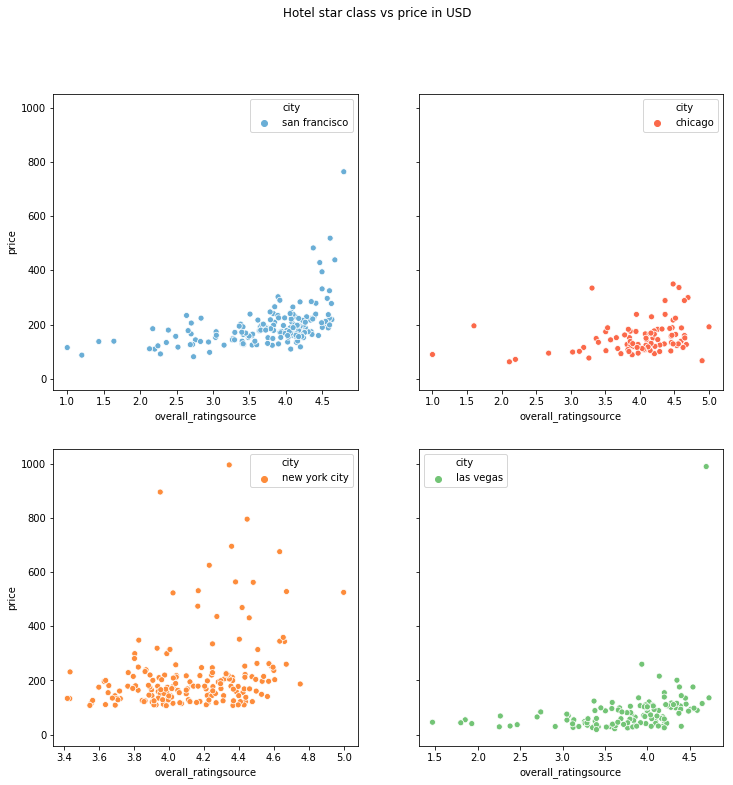

In [10]:
f, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

sns.scatterplot(x="overall_ratingsource", y="price", data=sanfran, palette='Blues', ax=axes[0, 0], hue='city')
sns.scatterplot(x="overall_ratingsource", y="price", data=iloveny, palette='Oranges', ax=axes[1, 0], hue='city')
sns.scatterplot(x="overall_ratingsource", y="price", data=eltrain, palette='Reds', ax=axes[0, 1], hue='city')
sns.scatterplot(x="overall_ratingsource", y="price", data=sincity, palette='Greens', ax=axes[1, 1], hue='city')

f.suptitle('Hotel ratings vs price in USD')
plt.show()

Hotels with higher star class and better ratings are more expensive, the trends seems mostly linear but for New York City. The hotels in Las Vegas seem to have a very weakly dependence on star rating, if any - that's because the business is not lodging anymore, but gambling. So the hotels an lower their prices to attract clients who gamble.

We are going to look at

* Linear and exponential trends of these dependencies.
* See if Las Vegas prices are independent of the star category


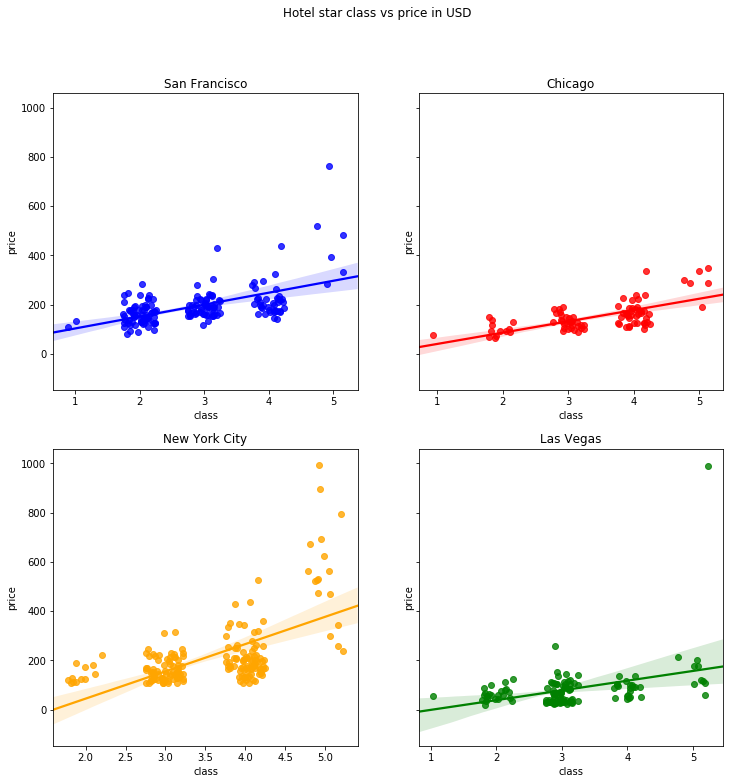

In [22]:
f, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

sns.regplot(x="class", y="price", data=sanfran, color='blue', ax=axes[0, 0], x_jitter=.25)
axes[0, 0].set_title('San Francisco')
sns.regplot(x="class", y="price", data=iloveny, color='orange', ax=axes[1, 0], x_jitter=.25)
axes[1, 0].set_title('New York City')
sns.regplot(x="class", y="price", data=eltrain, color='red', ax=axes[0, 1], x_jitter=.25)
axes[0, 1].set_title('Chicago')
sns.regplot(x="class", y="price", data=sincity, color='green', ax=axes[1, 1], x_jitter=.25)
axes[1, 1].set_title('Las Vegas')

f.suptitle('Hotel star class vs price in USD')
plt.show()

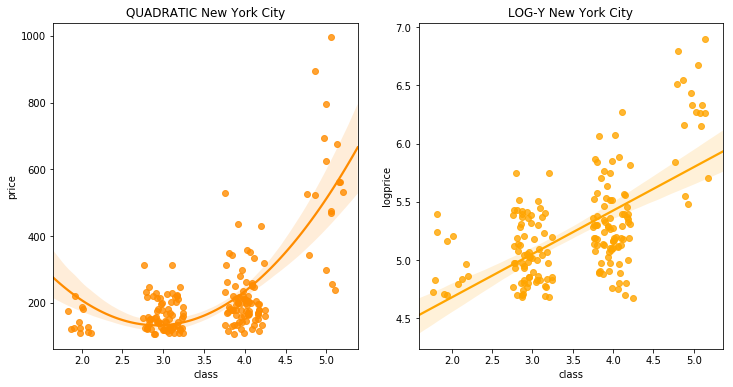

In [30]:
# NYC seems exponential or quadratic... can we try fit to it like that?

f, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.regplot(x="class", y="price", data=iloveny, color='darkorange', ax=axes[0], x_jitter=.25, order = 2)
axes[0].set_title('QUADRATIC New York City')
ilovenylog = iloveny.copy()
ilovenylog['logprice']=np.log(ilovenylog['price'])
sns.regplot(x="class", y="logprice", data=ilovenylog, color='orange', ax=axes[1], x_jitter=.25)
axes[1].set_title('LOG-Y New York City')

plt.show()

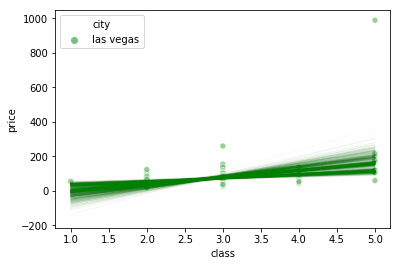

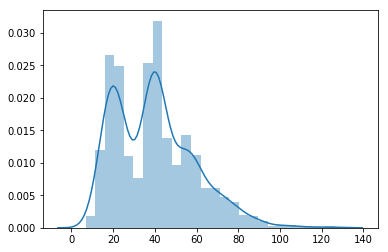

Probability of independence between stars and price in Las Vegas =  0.0


In [37]:

# bootstrapping function for linear regressions
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    inds = np.arange(len(x))
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y,1)

    return bs_slope_reps, bs_intercept_reps


nfits = 2000

vegasslopes, vegasintercepts = draw_bs_pairs_linreg(sincity['class'].values, sincity['price'].values, size=nfits)

sns.scatterplot(x='class', y='price', data=sincity, palette='Greens', hue='city', alpha=0.75)
x = np.array([1, 5])
for i in range(nfits):
    plt.plot(x, vegasslopes[i] * x + vegasintercepts[i], linewidth=0.5, alpha=0.025, color='green')
plt.show()

# We also want the distributions of slopes...
sns.distplot(vegasslopes)
plt.show()

# probability of slope <= 0
prob_flat = np.sum(vegasslopes<=0)/nfits
print('Probability of independence between stars and price in Las Vegas = ', prob_flat)

It seems that the prices in NY are linear under 2 stars, and quadratic from 2 to 5 stars... or it could be two lines, at the end, there is only 4 points (2,3,4 and 5 stars).

There is enough significance to say that the hotel prices in Las Vegas **depend** on the star rating, even if it is weakly or weaker than other cities.

Let's look at the user ratings:


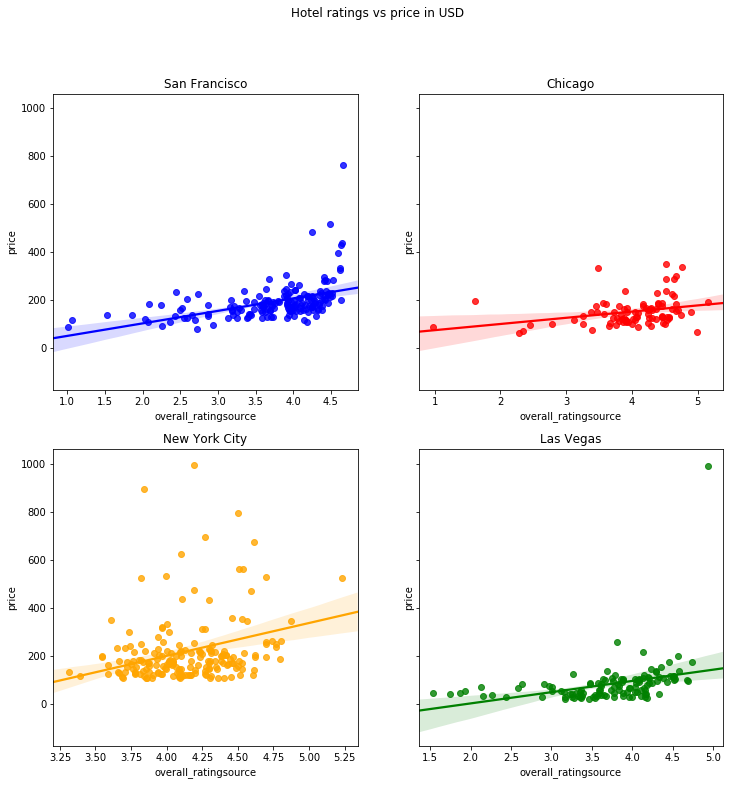

In [38]:
f, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

sns.regplot(x="overall_ratingsource", y="price", data=sanfran, color='blue', ax=axes[0, 0], x_jitter=.25)
axes[0, 0].set_title('San Francisco')
sns.regplot(x="overall_ratingsource", y="price", data=iloveny, color='orange', ax=axes[1, 0], x_jitter=.25)
axes[1, 0].set_title('New York City')
sns.regplot(x="overall_ratingsource", y="price", data=eltrain, color='red', ax=axes[0, 1], x_jitter=.25)
axes[0, 1].set_title('Chicago')
sns.regplot(x="overall_ratingsource", y="price", data=sincity, color='green', ax=axes[1, 1], x_jitter=.25)
axes[1, 1].set_title('Las Vegas')

f.suptitle('Hotel ratings vs price in USD')
plt.show()

Again, in NYC there is a lot of scater and seems hard to tell if it's actually linear.

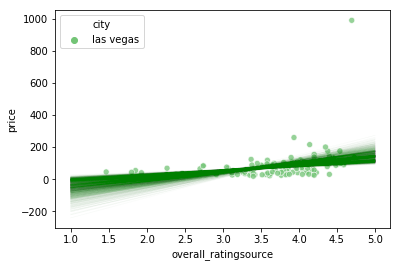

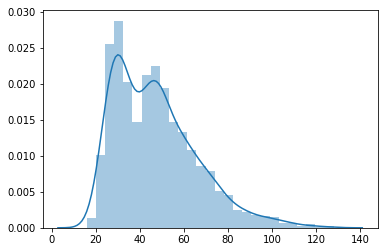

Probability of independence between rating and price in Las Vegas =  0.0


In [39]:

nfits = 2000

vegasslopes, vegasintercepts = draw_bs_pairs_linreg(sincity['overall_ratingsource'].values, sincity['price'].values, size=nfits)

sns.scatterplot(x='overall_ratingsource', y='price', data=sincity, palette='Greens', hue='city', alpha=0.75)
x = np.array([1, 5])
for i in range(nfits):
    plt.plot(x, vegasslopes[i] * x + vegasintercepts[i], linewidth=0.5, alpha=0.025, color='green')
plt.show()

# We also want the distributions of slopes...
sns.distplot(vegasslopes)
plt.show()

# probability of slope <= 0
prob_flat = np.sum(vegasslopes<=0)/nfits
print('Probability of independence between rating and price in Las Vegas = ', prob_flat)

The trend on star class or user ratings vs price are very homogeneous. Could it be enough to use one or the other **only** to cluster the hotels? I will leave that as an open question for now.

Move onto a specific rating vs price now. A very important factor is the location of a hotel. We are going to look at

* Location rating vs zip
* Map of hotels colored by location rating (along with lat-lon dataset for the zip codes)

The maps do not have the edge of the city/state. This is not very useful as is, but with the background map could have potential meaning.

In [40]:
# load zip codes and merge them onto the big dataset...

ziplatlon = pd.read_csv('ziplatlon.csv',index_col=False)
dfbtr1 = dfbtr1.merge(ziplatlon, left_on='zip', right_on='ZIP', how='inner')
dfbtr1 = dfbtr1.drop('ZIP', axis=1)

dfbtr1.head()

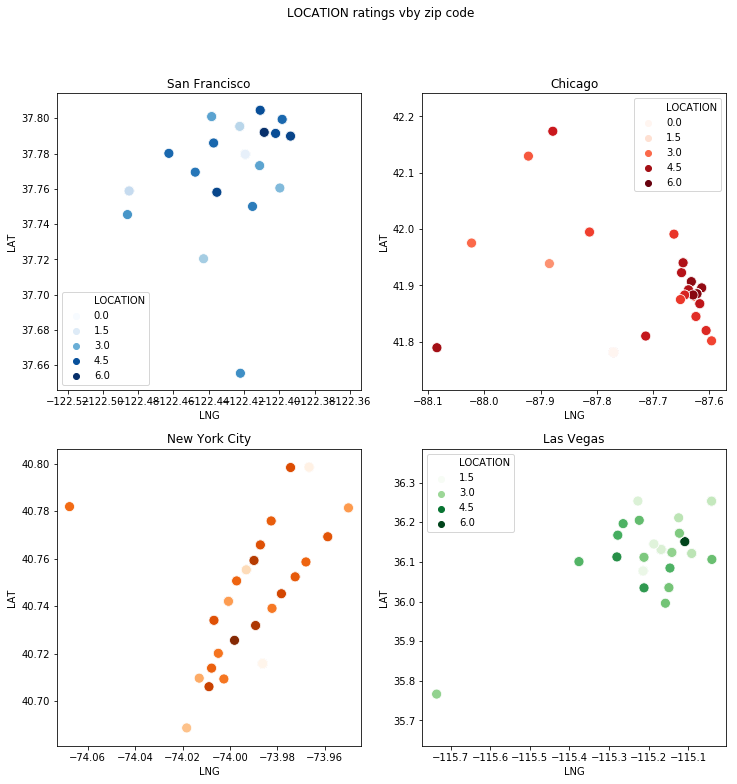

In [66]:
# without background map:

sanfran2 = dfbtr1[dfbtr1['city']=='san francisco']
iloveny2 = dfbtr1[dfbtr1['city']=='new york city']
eltrain2 = dfbtr1[dfbtr1['city']=='chicago']
sincity2 = dfbtr1[dfbtr1['city']=='las vegas']

f, axes = plt.subplots(2, 2, figsize=(12, 12))
sns.scatterplot(x="LNG", y="LAT", data=sanfran2, palette='Blues', ax=axes[0, 0], hue='LOCATION', x_jitter=0.1, y_jitter=0.1, s=100)
axes[0, 0].axis('equal')
#axes[0, 0].axis([-122.3, -122.6, 37.6, 37.9])
axes[0, 0].set_title('San Francisco')
sns.scatterplot(x="LNG", y="LAT", data=iloveny2, palette='Oranges', legend = False, ax=axes[1, 0], hue='LOCATION', s=100, x_jitter=0.1, y_jitter=0.1)
axes[1, 0].axis('equal')
axes[1, 0].set_title('New York City')
sns.scatterplot(x="LNG", y="LAT", data=eltrain2, palette='Reds', ax=axes[0, 1], hue='LOCATION', s=100, x_jitter=0.1, y_jitter=0.1)
axes[0, 1].axis('equal')
axes[0, 1].set_title('Chicago')
sns.scatterplot(x="LNG", y="LAT", data=sincity2, palette='Greens', ax=axes[1, 1], hue='LOCATION', s=100, x_jitter=0.1, y_jitter=0.1)
axes[1, 1].axis('equal')
axes[1, 1].set_title('Las Vegas')

f.suptitle('LOCATION ratings vby zip code')
plt.show()

We observe poor locations next to good locations. That is telling us that there are great differences within the same area, hence it is the neighbourhood that makes a difference, rather than being close or far to the city center. 

Let me plot one more correlation in there:

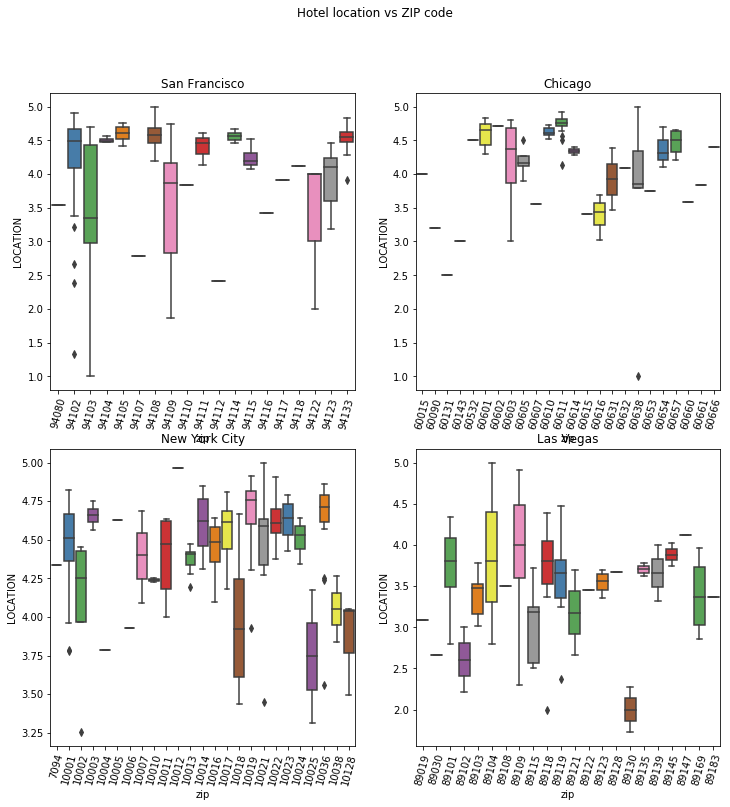

In [97]:
# repeat on box plot

f, axes = plt.subplots(2, 2, figsize=(12, 12))

sns.boxplot(y="LOCATION", x="zip", data=sanfran, palette='Set1', ax=axes[0, 0])
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=75)
axes[0, 0].set_title('San Francisco')
sns.boxplot(y="LOCATION", x="zip", data=iloveny,palette='Set1', ax=axes[1, 0])
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=75)
axes[1, 0].set_title('New York City')
sns.boxplot(y="LOCATION", x="zip", data=eltrain, palette='Set1', ax=axes[0, 1])
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=75)
axes[0, 1].set_title('Chicago')
sns.boxplot(y="LOCATION", x="zip", data=sincity, palette='Set1', ax=axes[1, 1])
axes[1, 1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=75)
axes[1, 1].set_title('Las Vegas')

f.suptitle('Hotel location vs ZIP code')
plt.show()

Indeed! It seems evident there are some zip codes people simply don't like, others that depends (and hence have large spread), and others that are liked by all. Does the price correlates with this?

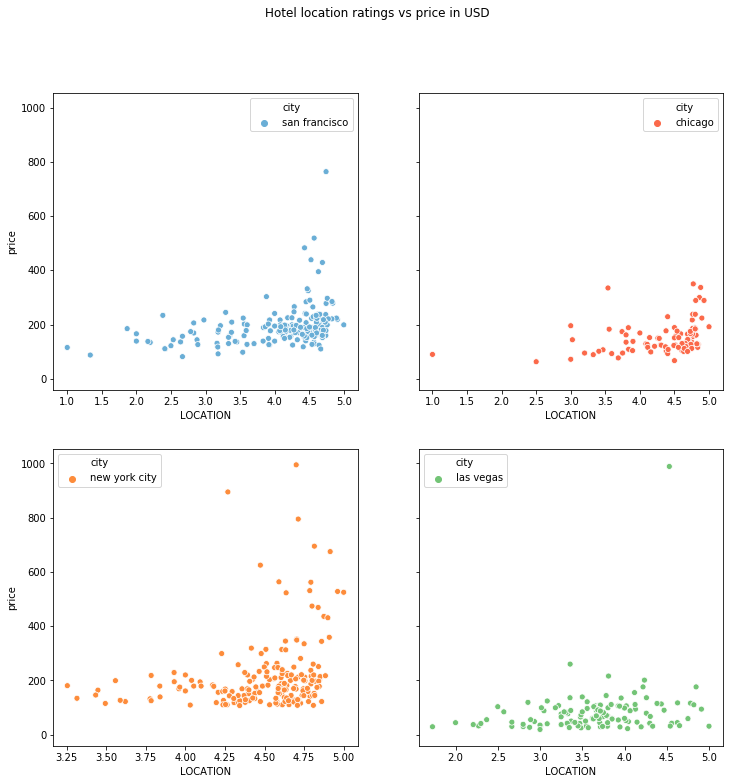

In [98]:
f, axes = plt.subplots(2, 2, figsize=(12, 12), sharey=True)

sns.scatterplot(x="LOCATION", y="price", data=sanfran, palette='Blues', ax=axes[0, 0], hue='city')
sns.scatterplot(x="LOCATION", y="price", data=iloveny, palette='Oranges', ax=axes[1, 0], hue='city')
sns.scatterplot(x="LOCATION", y="price", data=eltrain, palette='Reds', ax=axes[0, 1], hue='city')
sns.scatterplot(x="LOCATION", y="price", data=sincity, palette='Greens', ax=axes[1, 1], hue='city')

f.suptitle('Hotel location ratings vs price in USD')
plt.show()

The price shows the same dependence here than in the previous price plots. It is too scattered to extract meaningful information.